# Tugas Besar Pembelajaran Mesin 2

Muhammad Rizki Duwinanto - 13515006<br/>
Kevin Erdiza Yogatama - 13515016<br/>
Edwin Rachman - 13515042

#### Pustaka Terkait

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
import time
import random
import matplotlib.pyplot as plt
import math

In [2]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1)

In [3]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

## 1.a. Create a Classifier 

#### Deskripsi Algoritma

Inisialisasi model neural network ini menggunakan langkah-langkah sebagai berikut:
1. Jumlah node setiap layer (parameter sizes) dispesifikasikan.
2. Bias dan weight untuk setiap layer setelah layer pertama dihitung secara acak.

Proses fitting model sebelumnya menggunakan algoritma sebagai berikut:
1. Dalam fungsi fit dibutuhkan parameter jumlah data training (training_data), jumlah epoch (epochs), ukuran mini-batch (mini_batch_size), dan learning rate (learning_rate). Momentum (parameter momentum) jika diinginkan juga dapat dispesifikasikan. Data validasi (parameter validation_data) dapat dispesifikasikan secara langsung atau didapatkan dari training data jika parameter validation_split dispesifikasikan.
2. Training data dibagi-bagi menjadi mini-batch berdasarkan ukuran mini-batch.
3. Weight dan bias baru dihitung per mini-batch menggunakan fungsi update_mini_batch yang mengimplementasikan stochastic gradient. Dalam implementasi stochastic gradient digunakan fungsi backpropagation.
4. Lakukan langkah 3 untuk setiap mini-batch
5. Hitung akurasi dan loss training menggunakan fungsi evaluate dengan input mini-batch pertama. Fungsi evaluate menghasilkan nilai akurasi dan loss berdasarkan hasil feed-forward sigmoid (fungsi feed_forward). Hasil feed-forward setiap data jika lebih dari 0.5 akan menghasilkan 1, jika tidak menghasilkan 0. Akurasi dihitung dari rasio jumlah data setelah feed-forward yang sama dengan labelnya dengan jumlah seluruh data. Loss dihitung dari selisih kuadrat antara label dengan hasil data setelah feed-forward setiap data dibagi dengan jumlah semua data.
6. Hitung akurasi dan loss validasi menggunakan fungsi evaluate dengan input validation_data.
7. Lakukan langkah 2-6 untuk setiap epoch

Untuk melakukan prediksi dapat digunakan fungsi predict dengan input test_data. Dalam fungsi ini setiap test_data akan dilakukan feed-forward seperti pada fungsi evaluate.

#### Source Code Program

In [4]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.rand(y, 1) for y in sizes[1:]]
        self.weights = [np.array([np.random.uniform(-0.05, 0.05, x) for i in range(0,y)]) for x,y in zip(sizes[:-1], sizes[1:])]
        self.history = d = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    def feed_forward(self, activation):
        for bias, weight in zip(self.biases, self.weights):
            activation = sigmoid(np.dot(weight, activation) + bias.transpose()[0])
        return activation
    
    def fit(self, training_data, epochs, mini_batch_size, learning_rate,
            momentum=0, validation_data=None, validation_split=0.0, verbose=1):
        if validation_split != 0.0 and not validation_data :
            training_data, validation_data = train_test_split(training_data, test_size=validation_split, random_state=42)
        n_training = len(training_data)
        if validation_data or validation_split != 0.0: 
            n_validation = len(validation_data)
            if verbose != 0:
                print("Train on {} samples, validate on {} samples".format(n_training, n_validation))
        for epoch in range(epochs):
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n_training, mini_batch_size)]
            previous_weights = self.weights
            previous_biases =self.biases
            first = True
            for mini_batch in mini_batches:
                if first: previous_weights, previous_biases = self.weights, self.biases
                start = time.time()
                previous_weights, previous_biases = self.update_mini_batch(mini_batch, 
                                                                           learning_rate,
                                                                           momentum, 
                                                                           previous_weights, 
                                                                           previous_biases)
                end = time.time() - start
            if validation_data or validation_split != 0:
                training_accuracy, training_loss = self.evaluate(mini_batches[0])
                validation_accuracy, validation_loss = self.evaluate(validation_data)
                self.history['acc'].append(training_accuracy)
                self.history['val_acc'].append(validation_accuracy)
                self.history['loss'].append(training_loss)
                self.history['val_loss'].append(validation_loss)
                if verbose == 1 :
                    print("Epoch {}/{} : {} s - loss: {} - acc: {} - val_loss: {} - val_acc: {}".format(epoch + 1, 
                                                                                                        epochs,
                                                                                                        end,
                                                                                                        training_loss,
                                                                                                        training_accuracy,
                                                                                                        validation_loss,
                                                                                                        validation_accuracy))
                elif verbose == 2 :
                    print("Epoch {} complete.".format(epoch + 1))
            else :
                if verbose != 0:
                    print("Epoch {} complete.".format(epoch + 1))
        
    def update_mini_batch(self, mini_batch, learning_rate, momentum, previous_weights, previous_biases):
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        for x, y in mini_batch:
            delta_nabla_bias, delta_nabla_weights = self.backpropagation(x, y)
            nabla_biases = [nb + dnb for nb, dnb in zip(nabla_biases, delta_nabla_bias)]
            nabla_weights = [nw + dnw for nw, dnw in zip(nabla_weights, delta_nabla_weights)]
        temp_weights = self.weights
        temp_biases = self.biases
        self.weights = [w + momentum * pw + (learning_rate/len(mini_batch)) * nw 
                        for w, nw, pw in zip(self.weights, nabla_weights, previous_weights)]
        self.biases = [b + momentum * pb + (learning_rate/len(mini_batch)) * nb 
                       for b, nb, pb in zip(self.biases, nabla_biases, previous_biases)]
        return (temp_weights, temp_biases)
        
    def backpropagation(self, x, y):
        nabla_bias = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = x
        activations = [x]
        z_vectors = []
        
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, activation) + bias.transpose()[0]
            z_vectors.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(z_vectors[-1])
        nabla_bias[-1] = delta
        delta_newaxis = delta[:, np.newaxis]
        m = len(activations[-2])
        activations_newaxis = activations[-2][:, np.newaxis].reshape(1, m)
        nabla_weights[-1] = np.dot(delta_newaxis, activations_newaxis)
        
        for layer in range(2, self.num_layers):
            z = z_vectors[-layer]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            nabla_bias[-layer] = delta
            delta_newaxis = delta[:, np.newaxis]
            m = len(activations[-layer-1].transpose())
            activations_newaxis = activations[-layer-1].transpose()[:, np.newaxis].reshape(1, m)
            nabla_weights[-layer] = np.dot(delta_newaxis, activations_newaxis)
        
        return (nabla_bias, nabla_weights)
    
    def evaluate(self, test_data):
        test_results = [(1 if self.feed_forward(x) * 2 >= 1 else 0, y) for x, y in test_data]
        accuracy = sum(int(x == y) for x, y in test_results)/len(test_results)
        loss = sum(math.pow((y - x), 2) for x, y in test_results)/len(test_results)
        return accuracy, loss
    
    def predict(self, test_data):
        test_results = [1 if self.feed_forward(x) * 2 >= 1 else 0 for x, y in test_data]
        return (test_results)
    
    def cost_derivative(self, output_activations, y):
        return np.squeeze(y - output_activations)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

#### Cara Pengunaan

In [5]:
neural_network = Network([4, 5, 10, 1])
neural_network.fit(train_data, 50, 5, 0.1, momentum=0.0001, validation_split=0.25, verbose=0)

Berikut adalah contoh penggunaan algoritma pada data latih iris. Namun, hasil tidak ditampilkan karena iris memiliki 3 label sedangkan classifier yang kami buat hanya biner. Untuk hasil classifier dapat dilihat pada bagian 1.b.2.

## 1.b.1 Explorasi Keras 

#### Deskripsi Algoritma

Pembelajaran akan menggunakan kakas keras dengan model <i>sequential</i> dan lapisan <i>dense</i> .Model akan memakai input layer sebanyak 1 neuron dengan bentuk input 4 sesuai jumlah attribute data latih, kemudian dengan 3 hidden layer masing-masing 2, 3, 4 neuron dan 1 output layer dengan 1 neuron. Optimizer yang dipakai adalah SGD, dengan perhitungan loss dengan Mean Squared Error, dan Metrics Accuracy. 

#### Source Code Program

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [7]:
network = Sequential()
network.add(Dense(1, activation='sigmoid', input_shape=(4,)))
network.add(Dense(2, activation='sigmoid'))
network.add(Dense(3, activation='sigmoid'))
network.add(Dense(4, activation='sigmoid'))
network.add(Dense(1, activation='sigmoid'))

In [8]:
network.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [9]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


<b>Percobaan pada iris</b>

In [10]:
history = network.fit(X_train, y_train, epochs=200, verbose=0, batch_size=1, validation_split=0.1)

In [11]:
score = network.evaluate(X_test, y_test, batch_size=1)

15/15 [==============================] - 0s 461us/step


In [12]:
print("Loss: {} %".format(score[0]*100.0))
print("Accuracy {} %".format(score[1]*100.0))

Loss: 53.069829941717515 %
Accuracy 46.666666666666664 %


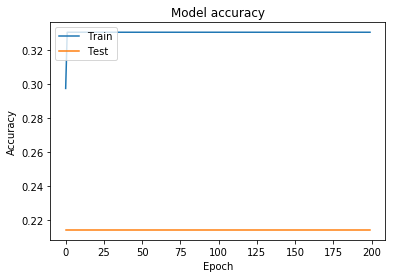

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

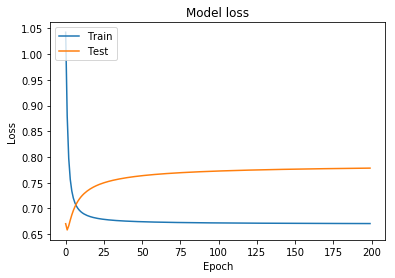

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 1.b.2 Eksperimen Data Categorization Framework

### 1.b.2.1 Persiapan Data

Hal pertama yang kami lakukan adalah menggunakan data latih Weather Categorization dari WEKA. 

In [15]:
weather_df = pd.read_csv('dataset/weather.csv')

weather_df

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes
5,rainy,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rainy,75,80,False,yes


Dapat dilihat data latih terdiri dari data numerik dan data kategorikal. Diperlukan preprocessing dengan kakas scikit-learn yaitu LabelEncoder sebagai berikut.

In [16]:
label_encoder = LabelEncoder()
weather_df['outlook'] = label_encoder.fit_transform(weather_df.outlook)
weather_df['windy'] = label_encoder.fit_transform(weather_df.windy)
weather_df['play'] = label_encoder.fit_transform(weather_df.play)

In [17]:
weather_df

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1
5,1,65,70,1,0
6,0,64,65,1,1
7,2,72,95,0,0
8,2,69,70,0,1
9,1,75,80,0,1


In [18]:
X_weather = weather_df.iloc[:,:4].values
X_weather

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1],
       [ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [19]:
y_weather = weather_df.play.values
y_weather

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Kemudian, setelah kami menjadikan data latih tersebut numerik, kami melakukan pemisahan sebagian data latih (10%) menjadi data uji dengan proporsi.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_weather, y_weather, test_size=0.1,shuffle=False)

In [21]:
X_train

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1]])

In [22]:
X_test

array([[ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [23]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [24]:
y_test

array([1, 0])

In [25]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

### 1.b.2.2 Batch = 1

Untuk perbandingan, seluruh classifier memiliki arsitektur [4, 10, 8, 1] baik di keras dan classifier sendiri. Kemudian epoch yang dipakai adalah berjumlah 100 untuk seluruh classifier. Lalu, validation data yang dipakai adalah 10% dari data latih. Terakhir, semua classifier memakai fungsi SGD (tidak ada adam). Batch pada eksperimen ini adalah satu.

#####  1.b.2.2.1 Classifier Sendiri

In [26]:
start = time.time()

In [27]:
neural_network1 = Network([4, 10, 8, 1])
neural_network1.fit(train_data, 100, 1, 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100 : 0.00011229515075683594 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/100 : 0.0001266002655029297 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/100 : 0.00012445449829101562 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/100 : 0.00012564659118652344 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/100 : 0.00012755393981933594 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/100 : 0.0001251697540283203 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/100 : 0.0006396770477294922 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/100 : 0.00011205673217773438 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/100 : 0.00012564659118652344 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/100 : 0.000110626220703125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/100 : 0.00012588500976

In [28]:
end = time.time() - start

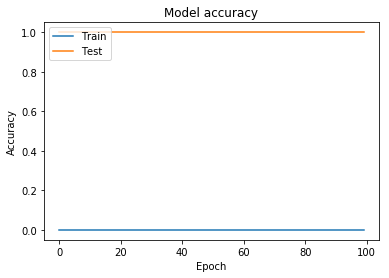

In [29]:
plt.plot(neural_network1.history['acc'])
plt.plot(neural_network1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

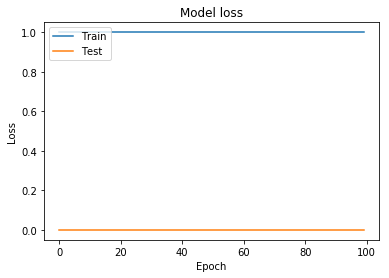

In [30]:
plt.plot(neural_network1.history['loss'])
plt.plot(neural_network1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
accuracy1, loss1 = neural_network1.evaluate(test_data)

In [32]:
print("Loss: {} %".format(loss1*100.0))
print("Accuracy {} %".format(accuracy1*100.0))
print("Time: {} ms".format(end))

Loss: 50.0 %
Accuracy 50.0 %
Time: 0.263641357421875 ms


##### 1.b.2.2.2 Keras Model

Reinitialisasi model keras untuk eksperimen pertama.

In [33]:
network1 = Sequential([
    Dense(10, activation='sigmoid', input_shape=(4,)),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [34]:
network1.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [35]:
network1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


In [36]:
start = time.time()

In [37]:
history1 = network1.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2860 - acc: 0.4000 - val_loss: 0.3737 - val_acc: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 923us/step - loss: 0.2829 - acc: 0.4000 - val_loss: 0.3652 - val_acc: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 844us/step - loss: 0.2801 - acc: 0.4000 - val_loss: 0.3569 - val_acc: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 807us/step - loss: 0.2775 - acc: 0.4000 - val_loss: 0.3490 - val_acc: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 934us/step - loss: 0.2751 - acc: 0.4000 - val_loss: 0.3414 - val_acc: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 766us/step - loss: 0.2728 - acc: 0.4000 - val_loss: 0.3339 - val_acc: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 950us/step - loss: 0.2706 - acc: 0.4000 - val_loss: 0.3268 - val_acc: 0.0000e+00

10/10 [==============================] - 0s 793us/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1841 - val_acc: 1.0000
Epoch 62/100
10/10 [==============================] - 0s 829us/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1833 - val_acc: 1.0000
Epoch 63/100
10/10 [==============================] - 0s 782us/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1826 - val_acc: 1.0000
Epoch 64/100
10/10 [==============================] - 0s 817us/step - loss: 0.2414 - acc: 0.6000 - val_loss: 0.1820 - val_acc: 1.0000
Epoch 65/100
10/10 [==============================] - 0s 823us/step - loss: 0.2414 - acc: 0.6000 - val_loss: 0.1813 - val_acc: 1.0000
Epoch 66/100
10/10 [==============================] - 0s 780us/step - loss: 0.2413 - acc: 0.6000 - val_loss: 0.1807 - val_acc: 1.0000
Epoch 67/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2413 - acc: 0.6000 - val_loss: 0.1801 - val_acc: 1.0000
Epoch 68/100
10/10 [==============================] - 0s 739us/step - loss: 0

In [38]:
end = time.time() - start

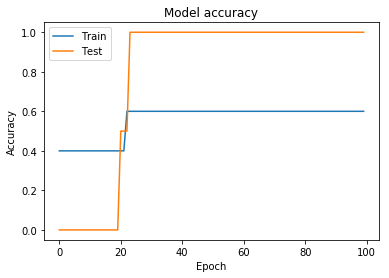

In [39]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

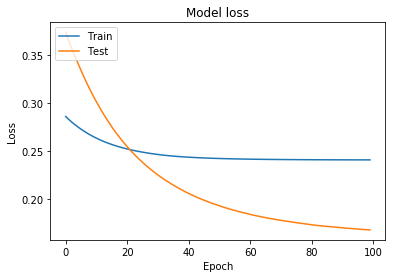

In [40]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
score1 = network1.evaluate(X_test, y_test, batch_size=1)

2/2 [==============================] - 0s 2ms/step


In [42]:
print("Loss: {} %".format(score1[0]*100.0))
print("Accuracy {} %".format(score1[1]*100.0))
print("Time: {} ms".format(end))

Loss: 25.88162273168564 %
Accuracy 50.0 %
Time: 1.3260552883148193 ms


### 1.b.2.3 Batch =  Jumlah Data Latih

Untuk perbandingan, seluruh classifier memiliki arsitektur [4, 10, 8, 1] baik di keras dan classifier sendiri. Kemudian epoch yang dipakai adalah berjumlah 100 untuk seluruh classifier. Lalu, validation data yang dipakai adalah 10% dari data latih. Terakhir, semua classifier memakai fungsi SGD (tidak ada adam). Batch pada eksperimen ini adalah panjang dari X_train.

##### 1.b.2.3.1 Classifier Sendiri

In [43]:
start = time.time()

In [44]:
neural_network2 = Network([4, 10, 8, 1])
neural_network2.fit(train_data, 100, len(X_train), 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100 : 0.0013234615325927734 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/100 : 0.001287698745727539 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/100 : 0.0010612010955810547 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/100 : 0.0011646747589111328 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/100 : 0.0010759830474853516 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/100 : 0.0013306140899658203 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/100 : 0.0012731552124023438 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/100 : 0.0009412765502929688 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/100 : 0.0011892318725585938 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/100 : 0.0011174678802490234 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/100 : 0.00118255615234375 s 

In [45]:
end = time.time() - start

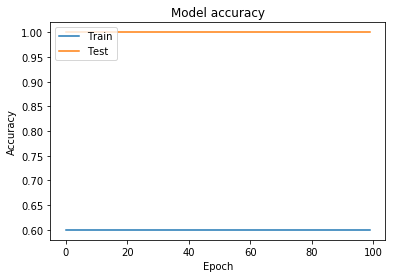

In [46]:
plt.plot(neural_network2.history['acc'])
plt.plot(neural_network2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

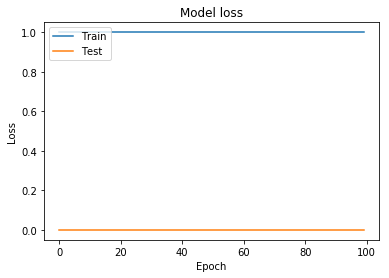

In [47]:
plt.plot(neural_network1.history['loss'])
plt.plot(neural_network1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
accuracy2, loss2 = neural_network2.evaluate(test_data)

In [49]:
print("Loss: {} %".format(loss2*100.0))
print("Accuracy {} %".format(accuracy2*100.0))
print("Time: {} ms".format(end))

Loss: 50.0 %
Accuracy 50.0 %
Time: 0.25930190086364746 ms


##### 1.b.2.3.2 Keras Model

Reinitialisasi model keras untuk eksperimen kedua.

In [50]:
network2 = Sequential([
    Dense(10, activation='sigmoid', input_shape=(4,)),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [51]:
network2.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [52]:
network2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


In [53]:
start = time.time()

In [54]:
history2 = network2.fit(X_train, y_train, epochs=100, batch_size=len(X_train), validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2659 - acc: 0.4000 - val_loss: 0.3114 - val_acc: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 167us/step - loss: 0.2656 - acc: 0.4000 - val_loss: 0.3106 - val_acc: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 225us/step - loss: 0.2654 - acc: 0.4000 - val_loss: 0.3097 - val_acc: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 201us/step - loss: 0.2651 - acc: 0.4000 - val_loss: 0.3089 - val_acc: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 133us/step - loss: 0.2649 - acc: 0.4000 - val_loss: 0.3080 - val_acc: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 161us/step - loss: 0.2646 - acc: 0.4000 - val_loss: 0.3072 - val_acc: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 149us/step - loss: 0.2644 - acc: 0.4000 - val_loss: 0.3064 - val_acc: 0.0000e+00

Epoch 61/100
10/10 [==============================] - 0s 128us/step - loss: 0.2545 - acc: 0.4000 - val_loss: 0.2680 - val_acc: 0.0000e+00
Epoch 62/100
10/10 [==============================] - 0s 161us/step - loss: 0.2544 - acc: 0.4000 - val_loss: 0.2674 - val_acc: 0.0000e+00
Epoch 63/100
10/10 [==============================] - 0s 134us/step - loss: 0.2543 - acc: 0.4000 - val_loss: 0.2668 - val_acc: 0.0000e+00
Epoch 64/100
10/10 [==============================] - 0s 115us/step - loss: 0.2541 - acc: 0.4000 - val_loss: 0.2662 - val_acc: 0.0000e+00
Epoch 65/100
10/10 [==============================] - 0s 136us/step - loss: 0.2540 - acc: 0.4000 - val_loss: 0.2657 - val_acc: 0.0000e+00
Epoch 66/100
10/10 [==============================] - 0s 163us/step - loss: 0.2539 - acc: 0.4000 - val_loss: 0.2651 - val_acc: 0.0000e+00
Epoch 67/100
10/10 [==============================] - 0s 130us/step - loss: 0.2537 - acc: 0.4000 - val_loss: 0.2645 - val_acc: 0.0000e+00
Epoch 68/100
10/10 [==============

In [55]:
end = time.time() - start

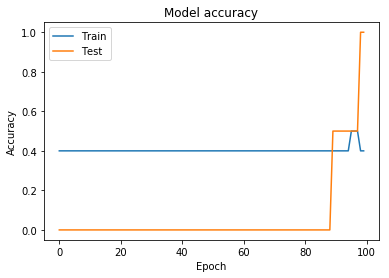

In [56]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

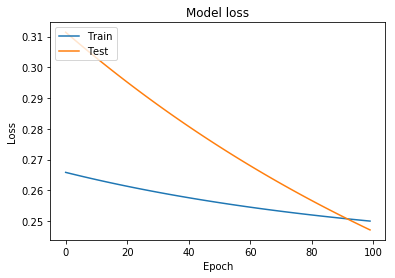

In [57]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
score2 = network2.evaluate(X_test, y_test, batch_size=len(X_train))

2/2 [==============================] - 0s 244us/step


In [59]:
print("Loss: {} %".format(score2[0]*100.0))
print("Accuracy {} %".format(score2[1]*100.0))
print("Time: {} ms".format(end))

Loss: 24.76743757724762 %
Accuracy 50.0 %
Time: 0.5902550220489502 ms


### 1.b.2.4 Analisis Eksperimen

Berdasarkan hasil eksperimen dengan classifier sendiri dan model keras, dapat disimpulkan dengan tabel berikut ini.

In [60]:
analysis_df = pd.DataFrame({'Classifier' : ['Classifier Sendiri', 'Keras Model', 'Classifier Sendiri', 'Keras Model'],
              'Batch' : [1, 1, len(X_train), len(X_train)],
              'Loss' :[loss1, score1[0], loss2, score2[0]],
              'Accuracy' :[accuracy1, score1[1], accuracy2, score2[1]]})
analysis_df.index += 1
analysis_df

,Classifier,Batch,Loss,Accuracy
1,Classifier Sendiri,1,0.500000,0.5
2,Keras Model,1,0.258816,0.5
3,Classifier Sendiri,12,0.500000,0.5
4,Keras Model,12,0.247674,0.5


Akurasi yang dihasilkan dari kedua classifier adalah sama. Namun, jika melihat dari perbandingan loss, terlihat bahwa classifier 4 memiliki loss terdikit dibandingkan yang lain. Lalu dari semua grafik loss dan accuracy, classifier 4 hanya memerlukan 90 epoch dan classifier 2 hanya memerlukan 20 epoch untuk fitting data. Sedangkan untuk seluruh classifier sendiri belum konvergen. Jika dibandingkan secara keseluruhan proses pembelajaran dari grafik loss dan accuracy, proses pembelajaran berjalan lebih baik di keras dikarenakan lebih teroptimasi daripada algoritma kami, sehingga memiliki performa yang lebih baik walaupun tidak memakai adam. 

Sehingga dapat disimpulkan bahwa classifier terbaik dalam eksperimen ini adalah yang memiliki loss terdikit yaitu classifier 4. Hal lain yang dapat disimpulkan adalah model keras masih lebih baik dari algoritma kami dalam proses pembelajaran.

### Pembagian Kerja

Muhammad Rizki Duwinanto - 13515006 : Algoritma, Keras, Laporan <br/>
Kevin Erdiza Yogatama - 13515016 : Algoritma, Keras, Laporan <br/>
Edwin Rachman - 13515042 : Algoritma, Keras, Laporan